# Outline
First off we give an overview of the analysis tasks
- Data Preprocessing
 - Missing Data
 - Outliners
- Basic Exploratory Data Analysis
- Feature Engineering
- Data Transformation
 - Numerical data
 - Categorical data
- ANN Model and training
- XGBoost Model and training
- Further Exploratory Data Analysis (EDA)
 - items that best sell together
 - sales relationship to weather or the day of the week
 - number of sales in a transaction of sales relationship to the time of day

# Problem Definition - Prediction Task
Given a data set of weather data (edinburgh-wx.csv) and datetime information, predict the hourly item sales of the bakery.

We selected two model for training: **Artifical Neural Network** using keras, and **XGBoost** algorithm.

# Data Preprocessing


### Weather data
We manage to join the weather data to the bakery sales data according to their hour in the day.
We oberve that the weather data reports twice in an hour (\*\*:20 and \*\*:50). 
Hence, we only select the weather at **:50 from the data set and now we obtain the every hour's weather data.

### Bakery data
In order to perform the prediction task. We categorise the bakery data according to their `Month`, `DayOfWeek`, `Hour`.
We create new feature for 
Inituitively, we suppose there are at most 12 unique values in `Month`, at most 7 unqiue values in `DayOfWeek`, at most 24 unique values in `Hour`.
In this way, we could give a clearer and useful label for transactions to belong in a specific time span.

### Joining tables
In order to join the table correctly, we join the table according to the key `Hour` and `Date` such that every entry from the bakery data set could align to the corresponding weather data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

df_bread = pd.read_csv('../input/xerini/BreadBasket_DMS.csv')
df_weather= pd.read_csv('../input/xerini/edinburgh-wx.csv')

df_bread['Date']=pd.to_datetime(df_bread.Date)
df_weather['Date']=pd.to_datetime(df_weather.Date)

# select the hour
df_bread['Hour'] = df_bread['Time'].str[:2]

# only selects results at **:50
df_weather = df_weather[df_weather.Time.str.endswith('50')]
df_weather['Hour'] = df_weather['Time'].str[:2]

# merge column
df = pd.merge(df_bread, df_weather, how='left', on=['Date','Hour'])

# new features
df['Day'] = df['Date'].dt.day.astype('object')
df['Month'] = df['Date'].dt.month.astype('object')
df['DoW'] = df.Date.dt.dayofweek.astype('object')

# new column: combine date and time to date time, for indexing use
df['Datetime'] = pd.to_datetime(df['Date'].dt.strftime('%d-%m-%Y') + df['Time_x'], format='%d-%m-%Y%H:%M:%S')

# count sales items per transaction (target)
df['Sales'] = df.groupby('Transaction')['Item'].transform('count')

### Missing Data
We check any missing data that may occur in the data set. 
Luckily enough, we do not found any missing data.

In [2]:
df.isna().sum()

Date            0
Time_x          0
Transaction     0
Item            0
Hour            0
Time_y          0
Temperature     0
Dew Point       0
Humidity        0
Wind            0
Wind Speed      0
Wind Gust       0
Pressure        0
Precip.         0
Precip Accum    0
Condition       0
Day             0
Month           0
DoW             0
Datetime        0
Sales           0
dtype: int64

### Outliners
#### Numerical columns
We also check any outliners from the numerical data. From the description, we still see the data are normal as well.

In [3]:
df.describe()

,Transaction,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.,Precip Accum,Sales
count,21293.000000,21293.000000,21293.000000,21293.000000,21293.000000,21293.000000,21293.00000,21293.0,21293.0,21293.000000
mean,4951.990889,45.402480,39.045179,79.470436,10.389048,1.663739,29.80866,0.0,0.0,3.050909
std,2787.758400,6.581891,5.822257,12.034101,6.245190,7.555482,0.40412,0.0,0.0,1.655106
min,1.000000,21.000000,19.000000,31.000000,0.000000,0.000000,28.80000,0.0,0.0,1.000000
25%,2548.000000,41.000000,36.000000,71.000000,6.000000,0.000000,29.50000,0.0,0.0,2.000000
50%,5067.000000,45.000000,39.000000,81.000000,9.000000,0.000000,29.90000,0.0,0.0,3.000000
75%,7329.000000,50.000000,43.000000,87.000000,14.000000,0.000000,30.10000,0.0,0.0,4.000000
max,9684.000000,61.000000,55.000000,100.000000,35.000000,47.000000,30.50000,0.0,0.0,12.000000


#### Categorical columns

We observed that there is some `Item` in transaction is labelled as `NONE` and `Adjustment`, which is literally meaningless.
We manage to remove these entry.

In [4]:
df.Item.unique()

array(['Bread', 'Scandinavian', 'Hot chocolate', 'Jam', 'Cookies',
       'Muffin', 'Coffee', 'Pastry', 'Medialuna', 'Tea', 'NONE',
       'Tartine', 'Basket', 'Mineral water', 'Farm House', 'Fudge',
       'Juice', "Ella's Kitchen Pouches", 'Victorian Sponge', 'Frittata',
       'Hearty & Seasonal', 'Soup', 'Pick and Mix Bowls', 'Smoothies',
       'Cake', 'Mighty Protein', 'Chicken sand', 'Coke',
       'My-5 Fruit Shoot', 'Focaccia', 'Sandwich', 'Alfajores', 'Eggs',
       'Brownie', 'Dulce de Leche', 'Honey', 'The BART', 'Granola',
       'Fairy Doors', 'Empanadas', 'Keeping It Local', 'Art Tray',
       'Bowl Nic Pitt', 'Bread Pudding', 'Adjustment', 'Truffles',
       'Chimichurri Oil', 'Bacon', 'Spread', 'Kids biscuit', 'Siblings',
       'Caramel bites', 'Jammie Dodgers', 'Tiffin', 'Olum & polenta',
       'Polenta', 'The Nomad', 'Hack the stack', 'Bakewell',
       'Lemon and coconut', 'Toast', 'Scone', 'Crepes', 'Vegan mincepie',
       'Bare Popcorn', 'Muesli', 'Crisps', 'Pi

In [5]:
print('check item entry: NONE')
print(df[df['Item']=='NONE'].count()[0])
df = df[df['Item']!='NONE']
print(df[df['Item']=='NONE'].count()[0])
print('check item entry: Adjustment')
print(df[df['Item']=='Adjustment'].count()[0])
df = df[df['Item']!='Adjustment']
print(df[df['Item']=='Adjustment'].count()[0])

check item entry: NONE
786
0
check item entry: Adjustment
1
0


In [6]:
df.head()

,Date,Time_x,Transaction,Item,Hour,Time_y,Temperature,Dew Point,Humidity,Wind,...,Wind Gust,Pressure,Precip.,Precip Accum,Condition,Day,Month,DoW,Datetime,Sales
0,2016-10-30,09:58:11,1,Bread,09,09:50,54,50,88,VAR,...,0,30.2,0.0,0.0,Fair,30,10,6,2016-10-30 09:58:11,1
1,2016-10-30,10:05:34,2,Scandinavian,10,10:50,55,50,82,W,...,0,30.2,0.0,0.0,Fair,30,10,6,2016-10-30 10:05:34,2
2,2016-10-30,10:05:34,2,Scandinavian,10,10:50,55,50,82,W,...,0,30.2,0.0,0.0,Fair,30,10,6,2016-10-30 10:05:34,2
3,2016-10-30,10:07:57,3,Hot chocolate,10,10:50,55,50,82,W,...,0,30.2,0.0,0.0,Fair,30,10,6,2016-10-30 10:07:57,3
4,2016-10-30,10:07:57,3,Jam,10,10:50,55,50,82,W,...,0,30.2,0.0,0.0,Fair,30,10,6,2016-10-30 10:07:57,3


In [7]:
df_pre_train = df.groupby(['Month', 'Hour', 'Day'],as_index=False).agg('max').sort_values(by='Datetime')

# Feature Engineering
In this section, we exploit our understanding from the data and the our knowledge to find some useful new features that can be created from the existing data.

### Weather properties(Fog, Rain, Cloud, Snow)
Given different weather condition, we consider extract from `Condition` and to group them into different weather condition. We create 4 columns of weather to indicate specific condition at the corresponding time.
- `Fog`: A binary feature indicates whether at the moment fogging
- `Rain`: An ordinal feature we divided into 3 levels: dizzle < light rain < rain
- `Cloud`:  A binary feature indicates whether at the moment cloudly
- `Snow`:  A binary feature indicates whether at the moment snowing

For a fair weather, which does not hold any of these properties. Below we display a distribution of data for different weather conditions.

<AxesSubplot:xlabel='Snow', ylabel='Count'>

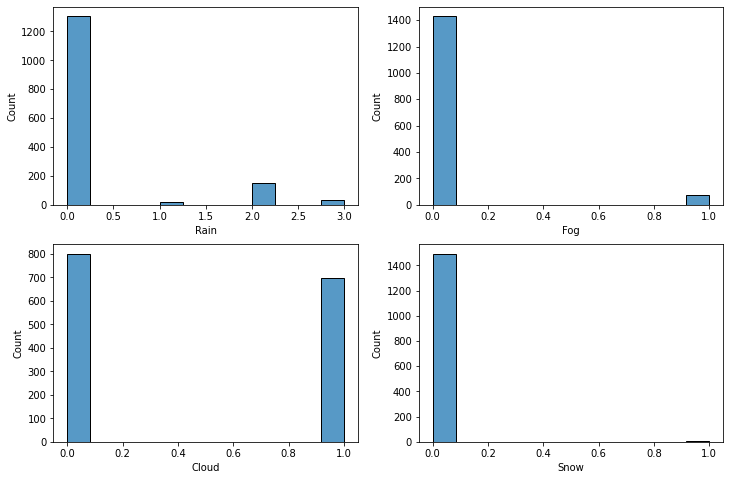

In [8]:
# Strip the text after slash
df_pre_train['Condition'] = df_pre_train.Condition.str.split('/').apply(lambda x: x[0]).str.strip()

fog = {'Fog':1, 'Mist':1, 'Patches ofog':1, 'Haze':1, 'Partialog':1, 'Shallowog':1}
cloud = {'Partly Cloudy':1, 'Cloudy':1, 'Mostly Cloudy':1}
rain = {'Light Drizzle':1, 'Drizzle':1, 'Light Rain':2, 'Light Rain Shower':2, 'Showers the Vicinity':3, 'Rain':3}
snow = {'Wintry Mix':1, 'Light Snow Shower':1, 'Light Snow Grains':1}

df_pre_train['Rain'] = df_pre_train.Condition.map(rain)
df_pre_train['Rain'].fillna(0,inplace=True)
df_pre_train['Fog'] = df_pre_train.Condition.map(fog)
df_pre_train['Fog'].fillna(0,inplace=True)
df_pre_train['Cloud'] = df_pre_train.Condition.map(cloud)
df_pre_train['Cloud'].fillna(0,inplace=True)
df_pre_train['Snow'] = df_pre_train.Condition.map(snow)
df_pre_train['Snow'].fillna(0,inplace=True)

fig, ax = plt.subplots(2,2,figsize=(12, 8))
sns.histplot(data=df_pre_train,x="Rain",ax=ax[0][0])
sns.histplot(data=df_pre_train,x="Fog",ax=ax[0][1])
sns.histplot(data=df_pre_train,x="Cloud",ax=ax[1][0])
sns.histplot(data=df_pre_train,x="Snow",ax=ax[1][1])

### Wind columns
We suppose that the wind direction has no major difference, so we redefine it as a  feature, which consist of
- **CALM**: no wind at the moment
- **VAR**: the wind direction is uncertain
- **ONEWAY**: the wind is in one-way directon

which reduces the category to 3 and makes the feature much less complex.

In [9]:
df_pre_train.Wind.unique()

array(['VAR', 'W', 'WSW', 'SSW', 'WNW', 'SW', 'NNW', 'NW', 'N', 'NNE',
       'SE', 'ESE', 'NE', 'ENE', 'S', 'E', 'CALM', 'SSE'], dtype=object)

<AxesSubplot:xlabel='Wind', ylabel='Count'>

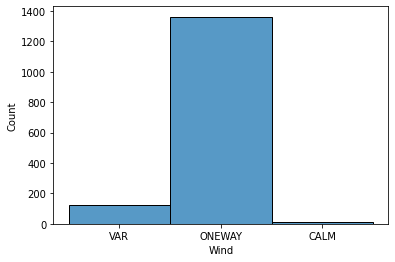

In [10]:
wind_oneway = ['W', 'WSW', 'SSW', 'WNW', 'SW', 'NNW', 'NW', 'N', 'NNE',
       'SE', 'ESE', 'NE', 'ENE', 'S', 'E', 'SSE']

df_pre_train['Wind'].replace(wind_oneway, 'ONEWAY', inplace=True)
sns.histplot(data=df_pre_train,x="Wind")

### Lagged Features
To deal with time-series data, we introduce new feature to exploit the properties of continuous-time data
- `lagged feature`: introduce lagged feature for sales data of *1,2,3,4,5,6,12* hours
- `rolling average`: backward rolling average of 12 hours

In [11]:
# lagged feature
def lag_feature(df, lags, col):
    for i in lags:
        shifted = df[['Month','Day','Hour',col]].copy()
        shifted.Sales = shifted.Sales.shift(i)
        shifted.columns = ['Month','Day','Hour', col+"_lag_"+str(i)]
        df = df.merge(shifted, on=['Month','Day','Hour'], how='left').fillna(0)
    return df

# Lagged feature
lagged = [1,2,3,4,5,6,12]
df_pre_train = lag_feature(df_pre_train, lagged, "Sales")

# rolling mean
y_lag = df_pre_train.Sales.shift(1)
df_pre_train['12ma'] = y_lag.rolling(12).mean().fillna(0)
df_pre_train.head()

,Month,Hour,Day,Date,Time_x,Transaction,Item,Time_y,Temperature,Dew Point,...,Cloud,Snow,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,Sales_lag_5,Sales_lag_6,Sales_lag_12,12ma
0,10,09,30,2016-10-30,09:58:11,1,Bread,09:50,54,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,10,30,2016-10-30,10:56:08,26,Tea,10:50,55,50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,11,30,2016-10-30,11:57:45,42,Tea,11:50,55,50,...,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,12,30,2016-10-30,12:59:29,58,Victorian Sponge,12:50,55,50,...,0.0,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10,13,30,2016-10-30,13:56:08,71,Victorian Sponge,13:50,57,50,...,0.0,0.0,5.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0


## Data selection
In this stage, we prepare the data and carefully select the useful columns for training to be used in next stage.

### Data Leakages
We do not use columns `Item` and `Transaction` for the prediction task. Because the information potential affect the prediction perfromance, in which the model will exploit these information predict the sales.

### Column `Wind Gust`
In this column, we can see no more than 5% of data contain value, which mean it holds more than 95% of missing data. 
So it is safe to remove the column.

In [12]:
df_pre_train[df_pre_train['Wind Gust']>0].count()[0]

67

### Column `Precip.`, `Precip Accum`
These two columns literally has no value, which contribute nothing to the data, so we can simply drop them.

In [13]:
df_pre_train[['Precip.', 'Precip Accum']].value_counts()

Precip.  Precip Accum
0.0      0.0             1501
dtype: int64

In [14]:
df_pre_train.head()

,Month,Hour,Day,Date,Time_x,Transaction,Item,Time_y,Temperature,Dew Point,...,Cloud,Snow,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,Sales_lag_5,Sales_lag_6,Sales_lag_12,12ma
0,10,09,30,2016-10-30,09:58:11,1,Bread,09:50,54,50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,10,30,2016-10-30,10:56:08,26,Tea,10:50,55,50,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,11,30,2016-10-30,11:57:45,42,Tea,11:50,55,50,...,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,12,30,2016-10-30,12:59:29,58,Victorian Sponge,12:50,55,50,...,0.0,0.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10,13,30,2016-10-30,13:56:08,71,Victorian Sponge,13:50,57,50,...,0.0,0.0,5.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0


# Basic Exploratory Data Analysis (EDA)
#### Data correlations
After preprocessing the data, here we have some visualizataion for the data correlations and distributions.

We first group the data by distinct time stamp (`Month`, `Day of week (DoW)`, `Hour`), we did consider the day of the month because it is not much related to our analysis focus.

Here we take a glimpse of how the data distribution looks like. 
As summary, we can see some sales pattern look like regarding to the `Month`, `Day of week` and `Hour`.
- `Month`: At the end of the year seem to have more sales than other months (we consider the months that have valid data records across)
- `Day of week`: Weekend seem to have more sales than weekdays.
- `Hour`: The item sales concentrates at the noon (around 10-14).

Also we give a short description to the weather data in Edinburgh in terms of `Temperature`, `Humidity`, and `Windspeed` from the time **30-Oct-2016** to **6-Apr-2017**.
- `Temperature`: Temperature in Edinburgh is around 50-55.
- `Humidity`: Edinburgh having around 80%-100% humidity
- `Windspeed`: has a median 15 of wind speed 

Detailed EDA to be described in later section.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


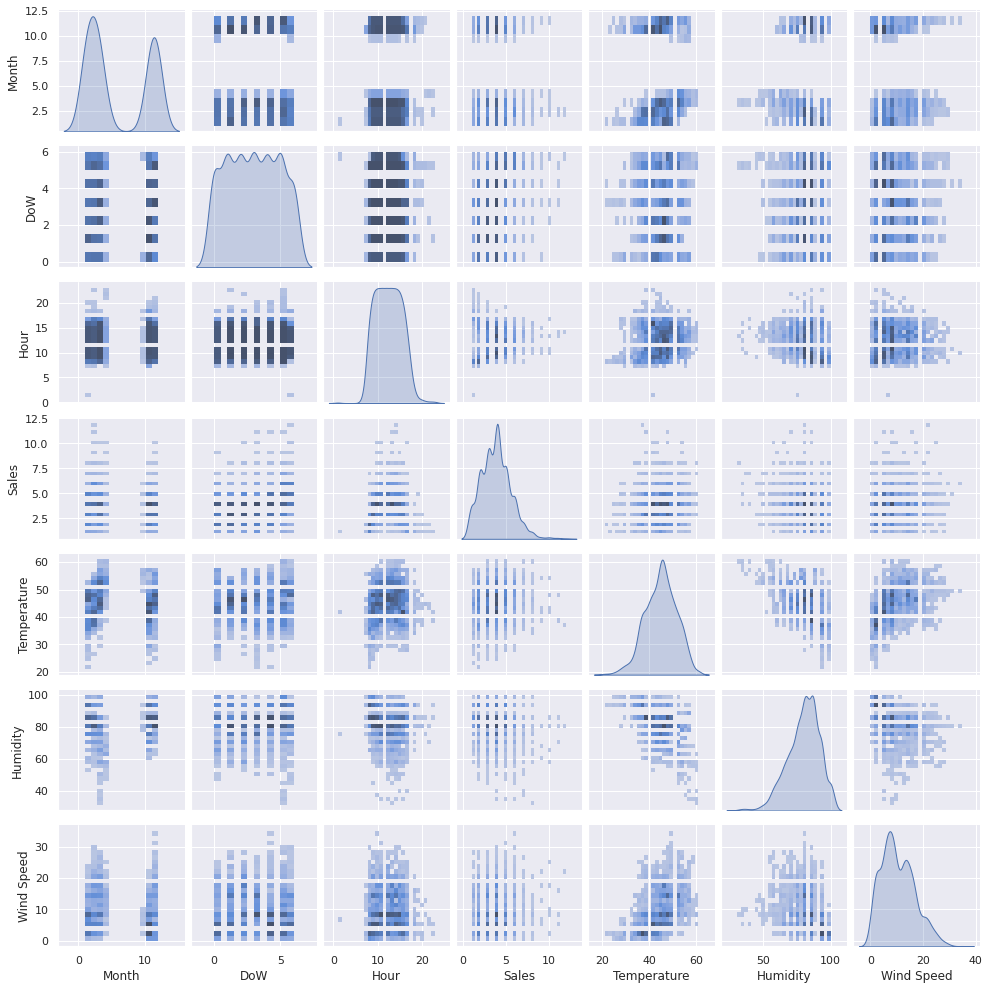

In [15]:
# convert hour column to int
df_pre_train['Hour'] = df_pre_train.Hour.astype('int')

sns.set()
columns = ['Month','DoW','Hour','Sales', 'Temperature','Humidity',"Wind Speed"]
sns.pairplot(df_pre_train[columns],size = 2 ,kind ='hist',diag_kind='kde')
plt.show()

### Sales trend
Here we visualize the average item per transaction with 50 average.

As shown in the graph it seems the average item purchase have increased since 2017.

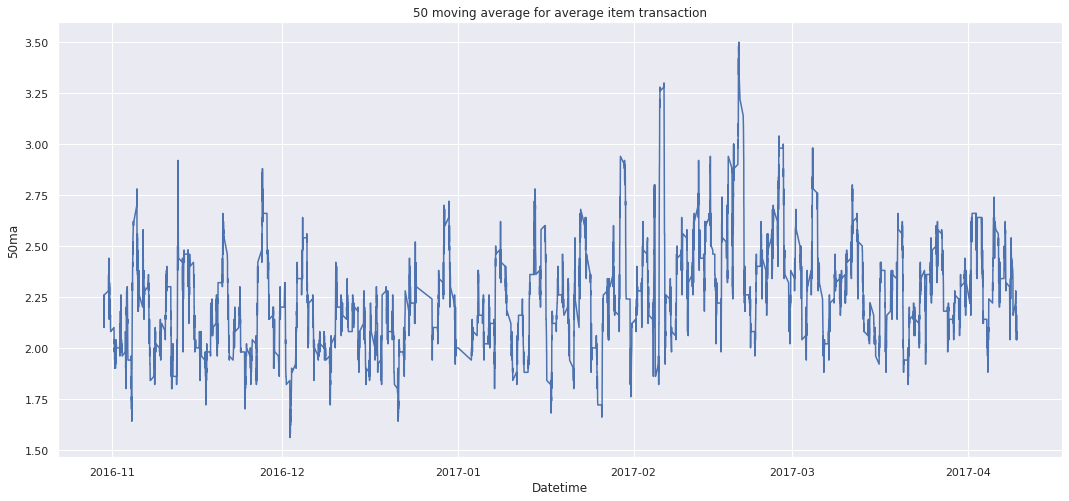

In [16]:
df_transaction_group = df.groupby('Transaction').agg({'Sales':'max',"Datetime":'max', 'DoW':'max'})
df_transaction_group['50ma'] = df_transaction_group['Sales'].rolling(window=50, center=False).mean()
plt.figure(figsize=(18,8))
ax = sns.lineplot(data=df_transaction_group,x='Datetime', y='50ma')
ax.set_title("50 moving average for average item transaction");

df_transaction_group['50ma'].fillna(0,inplace=True)

### Items purchase per transaction

First we group all items in same transaction to a same row and aggregate with a count number.

Here is the item per transaction distribution, we can see most of the customer purchase 1 or 2 items at a time.

<AxesSubplot:title={'center':'Item per transaction'}, xlabel='Sales', ylabel='count'>

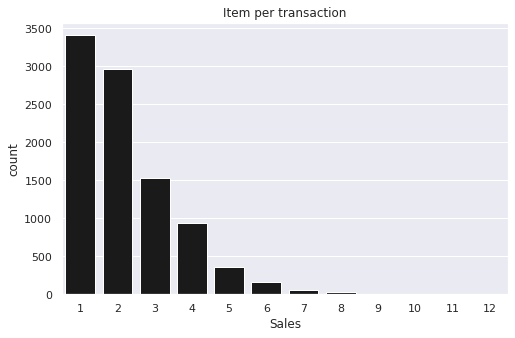

In [17]:
plt.figure(figsize=(8,5))
plt.title('Item per transaction')
sns.countplot(data=df_transaction_group, x="Sales", color="k")

#### Item Sales
In the figure we display the top-20 items sold by the bakery during the period. 

From the table we can observe that **coffee** is the best selling product.

Top 5 best selling products are **Coffee**, **Bread**, **Tea**, **Cake**, and **Pastry** respectively.

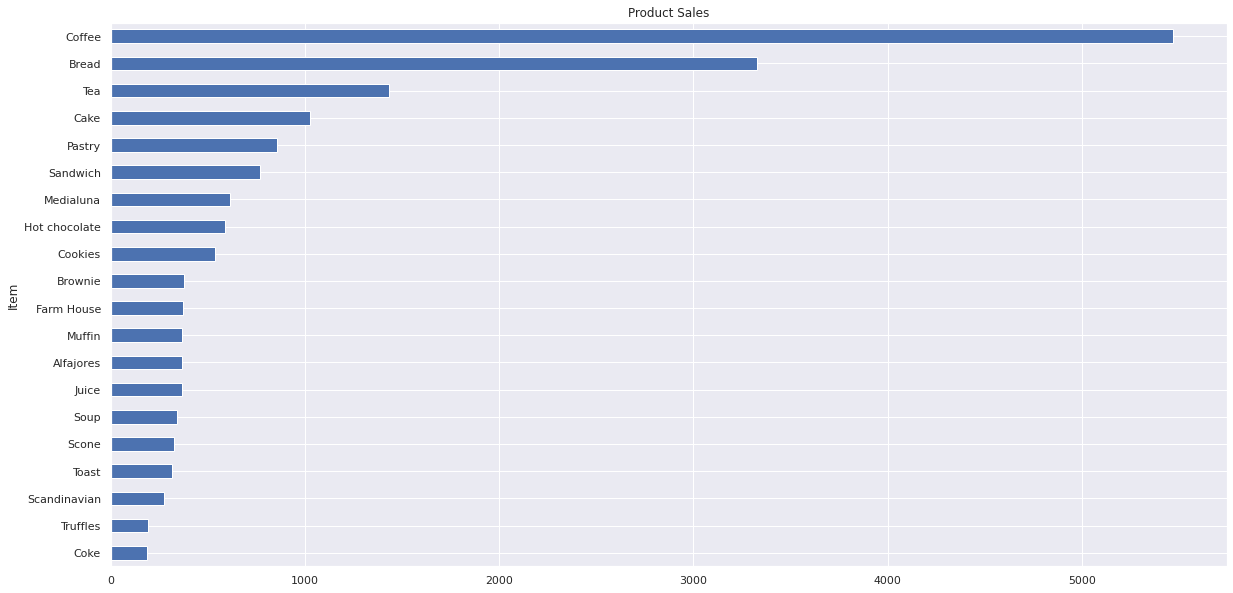

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
# group the item count all time
fi = df.groupby('Item').agg('count').iloc[:,0]
fi.sort_values(ascending=False)[0:20][::-1].plot(kind = 'barh')
plt.title('Product Sales')
plt.show()

## Encoding and Transformations
Before we put the data to the training model, we have to modify the data such that they are valid and are correct in scale.

Some columns need to transform the data format, like Hour, DoW, Month are categorical columns. 

### Data selection
We select the data column based on the criteria that have been considered in the data pre-processing section.

### Dataset(Train/Test/Validation)
Here we define the data set spliting to be used in this stage. We split the data set into two sets:
- Train set used for model training task
- Test set for evaluation after training

For time-series data spliting, we split the transaction data which is after `15-Mar-2017` to be test data set.

### Target
The target of our prediction task is the number of items sold in a specific time span (Month, Day of Week, Hour).

To achieve that, we have to group the data by the `Month`, `Hour` and `Day`. 

### Numerical columns transformation
For numerical columns like `temperature`, `humidity`, we apply scaling to normalize these column's mean center at 0.

### Categorical columns transformation
For columns like `Month`, `Hour` and `DoW` are treated as categorical features. We apply one-hot encoder to transform the categorical columns into one-hot vector.

After transformations, there are around ~50 columns in total.

In [19]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# New feature 'Rain', 'Fog', 'Cloud', 'Snow'
# New feature 'Sales_lag_x', '7ma'
# Remove 'Item', 'Transaction'
# emove 'Wind Gust', missing values
# remove'Precip.','Precip Accum', only 1 unique value
cols = ['Datetime','Month', 'DoW', 'Hour', 'Temperature','Dew Point','Humidity', 'Rain', 'Fog', 'Cloud', 'Snow','Wind','Wind Speed','Pressure',
        '12ma','Sales_lag_1','Sales_lag_2','Sales_lag_3','Sales_lag_4','Sales_lag_5','Sales_lag_6','Sales_lag_12']

# we transform the columns into correct data format
df_pre_train['Month']=df_pre_train['Month'].astype('object')
df_pre_train['Hour']=df_pre_train['Hour'].astype('object')
df_pre_train['DoW']=df_pre_train['DoW'].astype('object')
df_pre_train['Rain']=df_pre_train['Rain'].astype('object')
df_pre_train['Fog']=df_pre_train['Fog'].astype('object')
df_pre_train['Snow']=df_pre_train['Snow'].astype('object')
df_pre_train['Cloud']=df_pre_train['Cloud'].astype('object')

# training set
df_train = df_pre_train[cols]
df_train.head()

# datetime for visualization indexing later
df_dt_index = df_pre_train['Datetime']

# split the test data after 15 Mar 2017
split_date='15-Mar-2017' 
df_train[df_train.Datetime>=split_date].sort_values(by='Datetime')
x_train = df_train.loc[df_train.Datetime <= split_date].copy()
x_test = df_train.loc[df_train.Datetime > split_date].copy()

# datetime for indexing results
x_train_datetime = x_train['Datetime']
x_test_datetime = x_test['Datetime']

# drop datetime column
x_train.drop('Datetime',axis=1,inplace=True)
x_test.drop('Datetime',axis=1,inplace=True)

# target label
Y_train = df_pre_train.loc[df_pre_train.Datetime <= split_date,['Sales']].copy().astype('float64')
Y_test = df_pre_train.loc[df_pre_train.Datetime > split_date,['Sales']].copy().astype('float64')
Y_train.rename(columns={'Sales':'Target'},inplace=True)
Y_test.rename(columns={'Sales':'Target'},inplace=True)

# Select categorical columns
categorical_cols = [cname for cname in df_train.columns if
                    df_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in df_train.columns if 
                df_train[cname].dtype in ['int64', 'float64']]

# One hot encoder
oh = OneHotEncoder(handle_unknown='ignore', sparse=False)
# combine value
values = x_train[categorical_cols].append(x_test[categorical_cols])
oh.fit(values)
OH_x_train = pd.DataFrame(oh.transform(x_train[categorical_cols]))
OH_x_test = pd.DataFrame(oh.transform(x_test[categorical_cols]))

# One-hot encoding removed index; put it back
OH_x_train.index = x_train.index
OH_x_test.index = x_test.index

# Remove categorical columns (will replace with one-hot encoding)
x_train = x_train.drop(categorical_cols, axis=1)
x_test = x_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
x_train = pd.concat([x_train, OH_x_train], axis=1)
x_test = pd.concat([x_test, OH_x_test], axis=1)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaling  = StandardScaler()

x_train[numerical_cols] = scaling.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaling.transform(x_test[numerical_cols])
x_train.head()

,Temperature,Dew Point,Humidity,Wind Speed,Pressure,12ma,Sales_lag_1,Sales_lag_2,Sales_lag_3,Sales_lag_4,...,35,36,37,38,39,40,41,42,43,44
0,1.600107,1.930964,0.622908,-1.095335,0.952672,-4.980498,-2.248880,-2.242495,-2.236152,-2.229851,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.758098,1.930964,0.033429,-0.776895,0.952672,-4.980498,-1.662786,-2.242495,-2.236152,-2.229851,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.758098,1.930964,0.033429,-0.299236,0.952672,-4.980498,0.681592,-1.657578,-2.236152,-2.229851,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.758098,1.930964,0.033429,-0.617676,0.952672,-4.980498,0.681592,0.682092,-1.652403,-2.229851,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2.074081,1.930964,-0.457804,-0.617676,0.952672,-4.980498,0.681592,0.682092,0.682595,-1.647261,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


# Model training
In this stage, we use the preprocessed data for training. This time we selected **Artificial Neural Networks** and **XGBoost** algorithm.

### Artifical Neural Networks
To implement the ANN model, we use keras (based tensorflow)
The ANN model a simple 4-layer neural network model, with 3 layer of hidden layer, and the last hidden layer connected to a single output at the end.
Each hidden layer use ReLU as activation function. Other parameters includes:

- hidden dimension: [128,128,32]
- Batch normalization
- early-stopping after 10 around
- learning rate: 0.01
- batch size: 16
- validation set: 10% for validation
- time-series cross-validation: 5 fold
- epochs: 20

The loss is calculated using root mean squared error(RMSE).

### Hyperparamter tuning
Here we apply hyperparamter tuning and search for best parameter. We use the GridSearchCV for the best parameter configurations. The module is from sklearn and allow searching parameter space by cross-validation evaluation with given metrics.

In [20]:
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.layers import ReLU,LeakyReLU,PReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
tf.random.set_seed(42)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

def create_model(learning_rate=0.01):
    # create model
    ann_model = Sequential([
        Dense(128),
        Activation('relu'),
        BatchNormalization(),
        Dense(128),
        Activation('relu'),
        BatchNormalization(),
        Dense(32),
        Activation('relu'),
        BatchNormalization(),
        Dense(1)
    ])
    optimize = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    ann_model.compile(loss=rmse,optimizer=optimize,metrics=[rmse])
    return ann_model

model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [16,32,64,128]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#epochs = [20,50,100]
param_grid = dict(batch_size=batch_size, learning_rate=learning_rate)#, epochs=epochs)
# Grid search method
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4, cv=TimeSeriesSplit(5))
grid_result = grid.fit(x_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

2022-05-20 12:19:59.797519: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-05-20 12:19:59.798249: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-05-20 12:19:59.809730: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-05-20 12:19:59.866879: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-05-20 12:20:00.227246: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-20 12:20:00.227267: I te

Best: -2.029353 using {'batch_size': 16, 'learning_rate': 0.01}
-3.992780 (0.196987) with: {'batch_size': 16, 'learning_rate': 0.001}
-2.029353 (0.387795) with: {'batch_size': 16, 'learning_rate': 0.01}
-9.386865 (10.505854) with: {'batch_size': 16, 'learning_rate': 0.1}
-29.845704 (41.912932) with: {'batch_size': 16, 'learning_rate': 0.2}
-111.594691 (80.895906) with: {'batch_size': 16, 'learning_rate': 0.3}
-4.007297 (0.354278) with: {'batch_size': 32, 'learning_rate': 0.001}
-2.738876 (0.541850) with: {'batch_size': 32, 'learning_rate': 0.01}
-11.600720 (7.895165) with: {'batch_size': 32, 'learning_rate': 0.1}
-30.074979 (16.485448) with: {'batch_size': 32, 'learning_rate': 0.2}
-72.536047 (50.208932) with: {'batch_size': 32, 'learning_rate': 0.3}
-4.094824 (0.482088) with: {'batch_size': 64, 'learning_rate': 0.001}
-3.554663 (0.337005) with: {'batch_size': 64, 'learning_rate': 0.01}
-25.417714 (12.158462) with: {'batch_size': 64, 'learning_rate': 0.1}
-52.714222 (40.674629) with: {

After the hyperparameter search, we can apply the best hyperparameter to the model.

In [21]:
ann_model = create_model(learning_rate=0.01)
model_history=ann_model.fit(x_train,Y_train,validation_split=0.1,
                             batch_size=16, epochs=20, callbacks=earlystop)

Epoch 1/20
71/71 [==============================] - 2s 8ms/step - loss: 2.3701 - rmse: 2.3606 - val_loss: 1.6889 - val_rmse: 1.6847
Epoch 2/20
71/71 [==============================] - 0s 4ms/step - loss: 1.5854 - rmse: 1.5784 - val_loss: 1.7905 - val_rmse: 1.7842
Epoch 3/20
71/71 [==============================] - 0s 4ms/step - loss: 1.5028 - rmse: 1.5019 - val_loss: 1.5262 - val_rmse: 1.5212
Epoch 4/20
71/71 [==============================] - 0s 4ms/step - loss: 1.4703 - rmse: 1.4665 - val_loss: 1.5695 - val_rmse: 1.5634
Epoch 5/20
71/71 [==============================] - 0s 4ms/step - loss: 1.4399 - rmse: 1.4356 - val_loss: 1.6294 - val_rmse: 1.6213
Epoch 6/20
71/71 [==============================] - 0s 4ms/step - loss: 1.4019 - rmse: 1.4017 - val_loss: 1.5864 - val_rmse: 1.5831
Epoch 7/20
71/71 [==============================] - 0s 4ms/step - loss: 1.3760 - rmse: 1.3761 - val_loss: 1.7071 - val_rmse: 1.6990
Epoch 8/20
71/71 [==============================] - 0s 4ms/step - loss: 1.36

### Training Loss
After training, we can observe from the figure that, the traininng loss decrease gradually, for the validation loss as well.


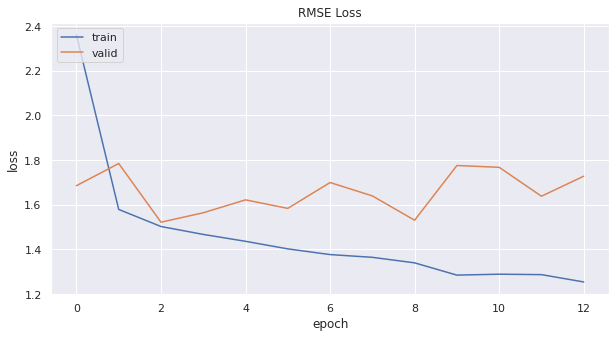

In [22]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10,5))
# summarize history for rmse
ax.plot(model_history.history['rmse'])
ax.plot(model_history.history['val_rmse'])
plt.title('RMSE Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

### Testing Set
To evaluate the performance, we let the ANN model to predict from the testing set.
The result shown as the RMSE loss.

In [23]:
from sklearn.metrics import mean_squared_error

ann_predictions = ann_model.predict(x_test)
ann_loss = np.sqrt(mean_squared_error(ann_predictions.squeeze(), Y_test))
print(f'Testing loss (RMSE): {ann_loss}')

Testing loss (RMSE): 1.8928396383220618


Now we check how the ANN's prediction align with target

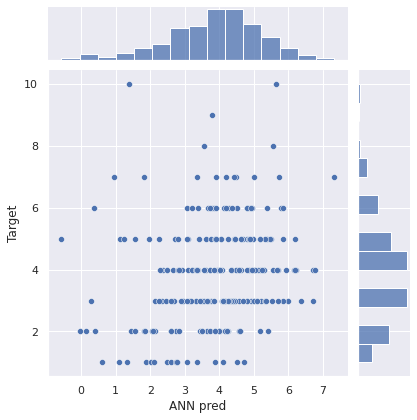

In [24]:
df_ann = pd.DataFrame(ann_predictions.squeeze(), columns=['ANN pred'])
# bind the index
df_ann.index = Y_test.index
sns.jointplot(data=pd.concat([x_test,df_ann,Y_test],axis=1), x="ANN pred", y="Target")

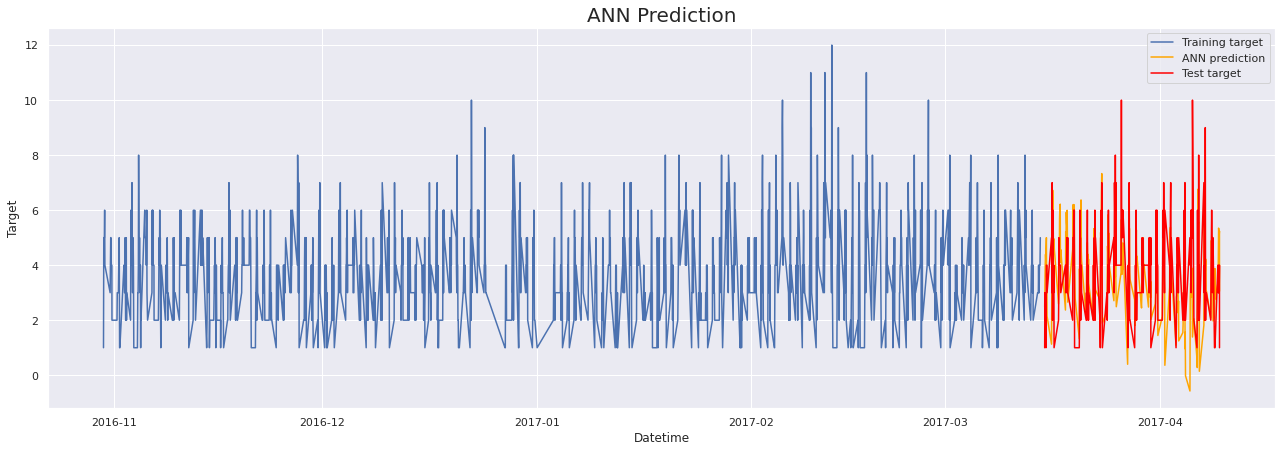

In [25]:
plt.figure(figsize=(22,7))
plt.title('ANN Prediction', size=20)
sns.lineplot(data=pd.concat([x_train_datetime,Y_train],axis=1),x='Datetime', y='Target', label='Training target')
sns.lineplot(data=pd.concat([x_test_datetime,df_ann],axis=1), x='Datetime', y="ANN pred", label='ANN prediction', color='orange')
sns.lineplot(data=pd.concat([x_test_datetime,Y_test],axis=1), x='Datetime', y="Target", label='Test target', color='red')
plt.legend();

### XGBoost model
Here we use XGBoost algorithm to perform the regression task.

#### Hyperparameter tuning
Here we perform a simple hyperparameter tuning for the XGBoost model. 
We define set of parameters of `estimators` and `learning_rate` that will be used for the testing independently in order to obtain the best set of hyper parameters.

In [26]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

estimators_param = [50,100,200]
learning_rate=[5e-3,2e-2,2e-5,1e-1]
for estimators in estimators_param:
    for lr in learning_rate:
        # Define model
        model = XGBRegressor(n_estimators=estimators, learning_rate=lr, n_jobs=4)
        rmse_score = np.sqrt(-1*cross_val_score(model, x_train, Y_train,cv=TimeSeriesSplit(5),scoring='neg_mean_squared_error').mean())
        print(f"estimator={estimators}, rmse={rmse_score},lr={lr}")

estimator=50, rmse=3.170273186976917,lr=0.005
estimator=50, rmse=2.1487261027121782,lr=0.02
estimator=50, rmse=3.805410678037644,lr=2e-05
estimator=50, rmse=1.662779753503057,lr=0.1
estimator=100, rmse=2.711822489063698,lr=0.005
estimator=100, rmse=1.7412676127218933,lr=0.02
estimator=100, rmse=3.8024309041447713,lr=2e-05
estimator=100, rmse=1.693735987810827,lr=0.1
estimator=200, rmse=2.15646731525137,lr=0.005
estimator=200, rmse=1.640803285389006,lr=0.02
estimator=200, rmse=3.796478643699041,lr=2e-05
estimator=200, rmse=1.7271418028993906,lr=0.1


After we obtain the best set of hyperparameters, we then implement the best parameters to predict the test set
- n_estimators: 200
- learning rate: 0.02

In [27]:
# Define model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=2e-2, n_jobs=4)

# Preprocessing of training data, fit model 
xgb_model.fit(x_train, Y_train)

# Preprocessing of validation data, get predictions
xgb_predictions = xgb_model.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(xgb_predictions, Y_test))

# Uncomment to print RMSE
print(f'Testing loss (RMSE): {rmse}')

Testing loss (RMSE): 1.5736533805258375


Now we check how the XGB's prediction align with target

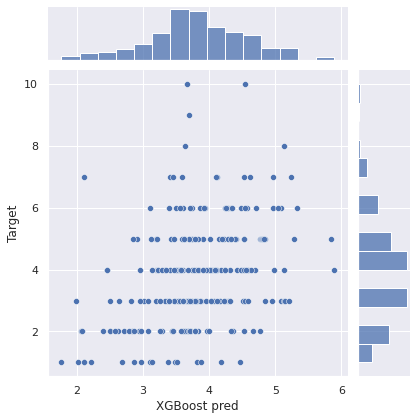

In [28]:
df_xgb = pd.DataFrame(xgb_predictions, columns=['XGBoost pred'])
# bind the index
df_xgb.index = Y_test.index
sns.jointplot(data=pd.concat([x_test,df_xgb,Y_test],axis=1), x="XGBoost pred", y="Target")

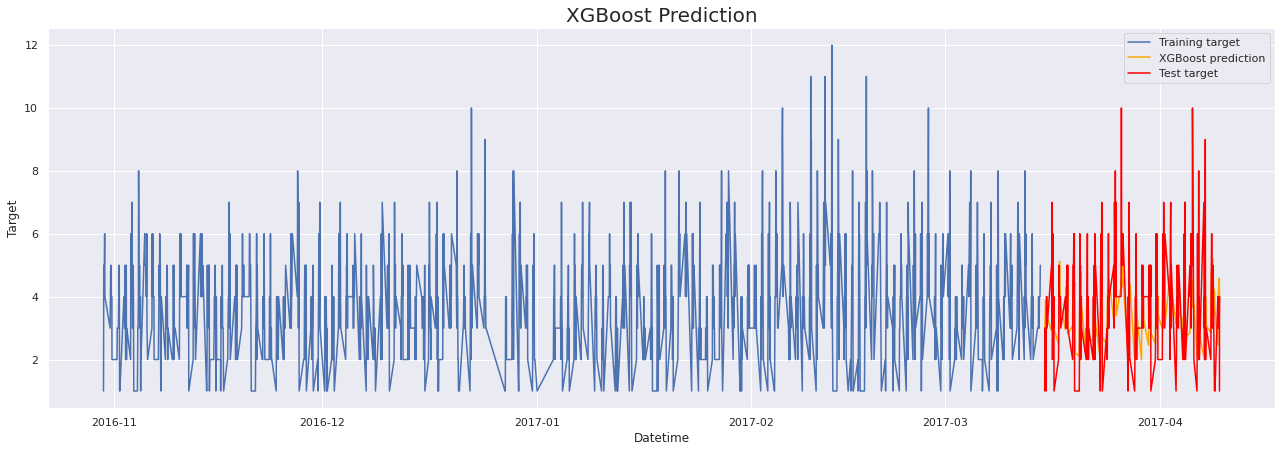

In [29]:
plt.figure(figsize=(22,7))
plt.title('XGBoost Prediction', size=20)
sns.lineplot(data=pd.concat([x_train_datetime,Y_train],axis=1),x='Datetime', y='Target', label='Training target')
sns.lineplot(data=pd.concat([x_test_datetime,df_xgb],axis=1), x='Datetime', y="XGBoost pred", label='XGBoost prediction', color='orange')
sns.lineplot(data=pd.concat([x_test_datetime,Y_test],axis=1), x='Datetime', y="Target", label='Test target', color='red')
plt.legend();

#### XGBoost Feature Importance
As a side note, we also show the most important factor in the XGBoost training

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

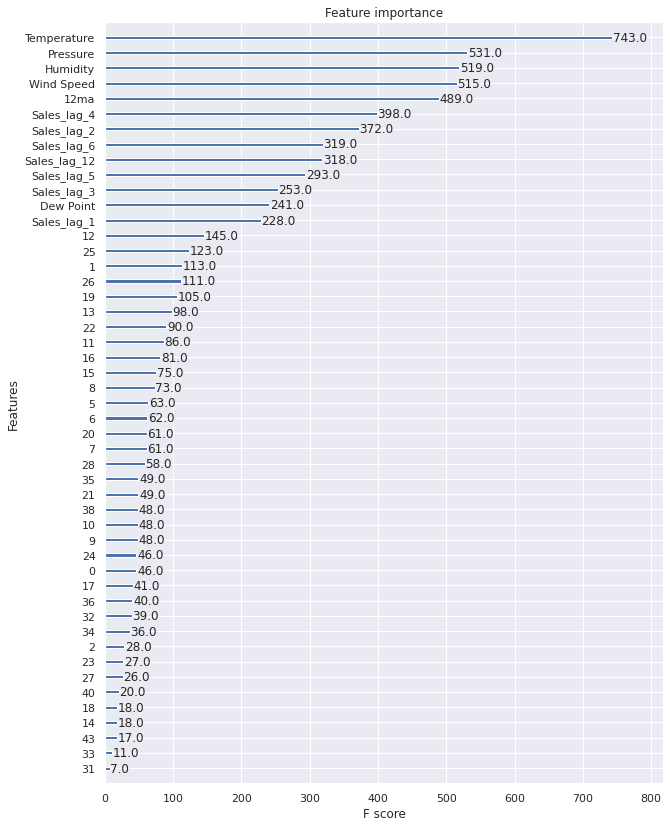

In [30]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_model, (10,14))

### Result
As result, the ANN model obtained RMSE score **1.892** on test set. On the other hand, XGBoost model has RMSE score of **1.573**.

As a preliminary study, we can see that the XGBoost algorithm outperforms the ANN model.

## Essemble Model
In addition, we can use the result by essembling both ANN and XGBoost model and obtain a better model for prediction.

As result we can see, the essembled model has a better result with lower RMSE score of 1.649

In [31]:
# Essemble predictions
essemble_predictions = 0.5 * ann_predictions.squeeze() + 0.5 * xgb_predictions

rmse = np.sqrt(mean_squared_error(essemble_predictions, Y_test))
print(f'Testing loss (RMSE): {rmse}')

Testing loss (RMSE): 1.6491256262686742


Now we check how the essemble model's prediction align with target

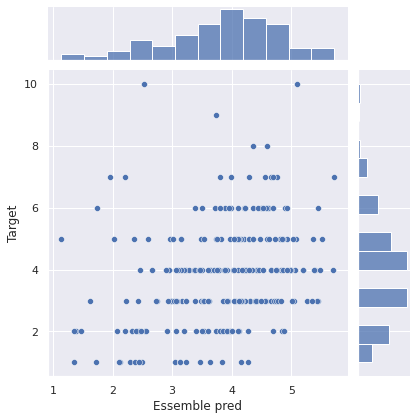

In [32]:
df_emb = pd.DataFrame(essemble_predictions, columns=['Essemble pred'])
# bind the index
df_emb.index = Y_test.index
sns.jointplot(data=pd.concat([x_test,df_emb,Y_test],axis=1), x="Essemble pred", y="Target")

We visualize the result from different models and compare to the true sales from the test set according to the time

<Figure size 864x504 with 0 Axes>

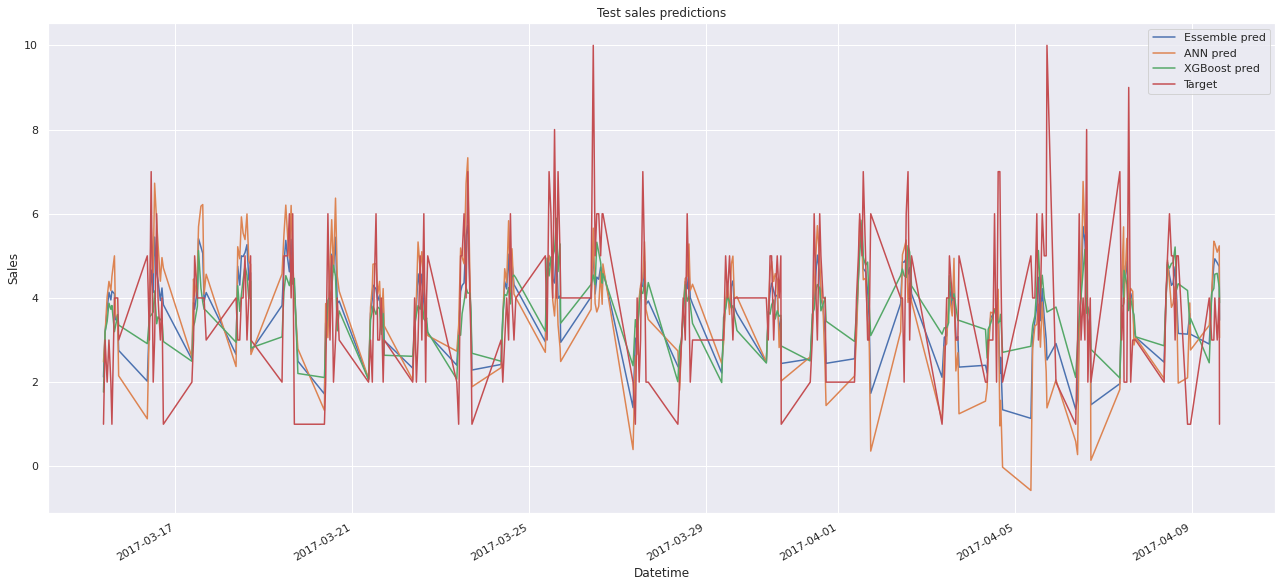

In [33]:
# merge the date with the result
df_preds = pd.DataFrame(df_dt_index).merge(df_emb, left_index=True, right_index=True) \
            .merge(df_ann, left_index=True, right_index=True) \
            .merge(df_xgb, left_index=True, right_index=True) \
            .merge(Y_test, left_index=True, right_index=True)

plt.figure(figsize=(12,7))
df_preds.set_index('Datetime').plot(title="Test sales predictions", ylabel="Sales", figsize=(22,10));

# Tasks - Exploratory Data Analysis
In this section, we perform  we perform the following tasks given in the document
- Items that best sell together
- Sales relationship to weather and the day of the week
- Number of sales in a transaction, relationship to the time of day

#### Items that best sell together - Apriori Algorithm
To analysis item that buy together most, we apply Apriori algorithm to analysis the basket data. We run the algorithm with threhold value 3%.

As result, we discover the following item sets are more likely to buy together
- 0.090016 	(Bread, **Coffee**)
- 0.054728 	(Cake, **Coffee**)
- 0.035182 	(**Coffee**, Medialuna)
- 0.047544 	(**Coffee**, Pastry)
- 0.038246 	(Sandwich, **Coffee**)
- 0.049868 	(Tea, **Coffee**)

In a nutshell, we see that people who buy (Bread, Cake, Medialuna, Pastry, Sandwich, Tea) are more likely to purchase **Coffee** as well.

In [34]:
# We group the items in same transaction into a single basket
basket = df.groupby('Transaction')['Item'].agg(lambda z: ','.join(z.values))
data = list(basket.apply(lambda x:x.split(",") ))

#Let's transform the list, with one-hot encoding
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

a = TransactionEncoder()
a_data = a.fit(data).transform(data)
df_apriori = pd.DataFrame(a_data,columns=a.columns_)
df_apriori = df_apriori.replace(False,0)
#set a threshold value for the support value and calculate the support value.
result = apriori(df_apriori, min_support = 0.03, use_colnames = True, verbose = 1)
result

Processing 42 combinations | Sampling itemset size 3


,support,itemsets
0,0.036348,(Alfajores)
1,0.32724,(Bread)
2,0.040046,(Brownie)
3,0.103867,(Cake)
4,0.478445,(Coffee)
5,0.054417,(Cookies)
6,0.039201,(Farm House)
7,0.058326,(Hot chocolate)
8,0.038567,(Juice)
9,0.061813,(Medialuna)


#### Association rule mining
Here is the result of association rule mining. We set the threshold to 50%, as shown in `confidence` column. 

In other words, people who purchase (**Cakes**, **Medialuna**, **Pastry** and **Sandwich**), would purchase 50% or more for **Coffee**.

In [35]:
#Let's view our interpretation values using the Associan rule function.
df_ar = association_rules(result, metric = "confidence", min_threshold = 0.5)
df_ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cake),(Coffee),0.103867,0.478445,0.054734,0.526958,1.101399,0.005039,1.102557
1,(Medialuna),(Coffee),0.061813,0.478445,0.035186,0.569231,1.189753,0.005612,1.210754
2,(Pastry),(Coffee),0.086116,0.478445,0.047549,0.552147,1.154046,0.006347,1.164569
3,(Sandwich),(Coffee),0.071851,0.478445,0.038250,0.532353,1.112674,0.003873,1.115276


## Sales relationship to weather and the day of the week - Average items per transaction analysis
In this section, we would like to discover the relation of `average items per transaction` to weather information

## Weather
Since the value of diffeernce is tiny, we can barely visualize them using graph.
Thus we would report the results through text.

We aggregate the items average purchased by customer in terms of following factors: `Fog`, `Rain`, `Cloud` and `Snow`.

In [36]:
# Strip the text after slash
df['Condition'] = df.Condition.str.split('/').apply(lambda x: x[0]).str.strip()

fog = {'Fog':1, 'Mist':1, 'Patches ofog':1, 'Haze':1, 'Partialog':1, 'Shallowog':1}
cloud = {'Partly Cloudy':1, 'Cloudy':1, 'Mostly Cloudy':1}
rain = {'Light Drizzle':1, 'Drizzle':1, 'Light Rain':2, 'Light Rain Shower':2, 'Showers the Vicinity':3, 'Rain':3}
snow = {'Wintry Mix':1, 'Light Snow Shower':1, 'Light Snow Grains':1}

df['Rain'] = df.Condition.map(rain)
df['Rain'].fillna(0,inplace=True)
df['Fog'] = df.Condition.map(fog)
df['Fog'].fillna(0,inplace=True)
df['Cloud'] = df.Condition.map(cloud)
df['Cloud'].fillna(0,inplace=True)
df['Snow'] = df.Condition.map(snow)
df['Snow'].fillna(0,inplace=True)


fog_sales = df.groupby('Transaction').agg('max').groupby(['Fog'])['Sales'].agg('mean')
rain_sales = df.groupby('Transaction').agg('max').groupby(['Rain'])['Sales'].agg('mean')
cloud_sales = df.groupby('Transaction').agg('max').groupby(['Cloud'])['Sales'].agg('mean')
snow_sales = df.groupby('Transaction').agg('max').groupby(['Snow'])['Sales'].agg('mean')

#### Rain
We can oberve that when there is raining, the average items per transaction per transaction jumps to 2.3+, while it is only ~2.23 when no rain. 

Remember 0 refers no rain, 1 refers drizzle, 2 refers light rain, 3 refers rain.

In [37]:
rain_sales

Rain
0.0    2.232197
1.0    2.323529
2.0    2.299076
3.0    2.372973
Name: Sales, dtype: float64

### Cloudy
Although there is a little correlation between the cloudly weather condition and the 
average items per transaction, however the value is not significant enough.

In [38]:
cloud_sales

Cloud
0.0    2.219980
1.0    2.269328
Name: Sales, dtype: float64

#### Fog
From the result, we can see there is no much difference between the fog day and the normal weather day.

In [39]:
fog_sales

Fog
0.0    2.242740
1.0    2.242081
Name: Sales, dtype: float64

#### Snow
when there is snow, the average items per transaction jump to 2.405 compare with 2.242 for other days

In [40]:
snow_sales

Snow
0.0    2.242071
1.0    2.405405
Name: Sales, dtype: float64

### Average item per transaction - day of week

From the figure below, we can observe that the average sales

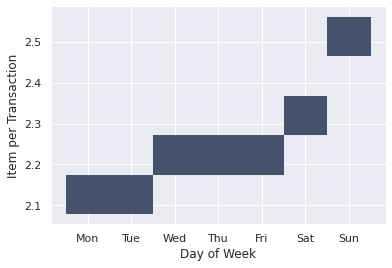

In [41]:
# we aggregate the mean for day of week
df_dow_avg_sales = df_transaction_group.groupby('DoW', as_index=False).agg('mean')

sns.histplot(x=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], y='Sales', data=df_dow_avg_sales, element='bars')
plt.xlabel('Day of Week')
plt.ylabel('Item per Transaction')
sns.despine()

## Number of sales in a transaction, relationship to the time of day
### Categorising the `Item` column
Since there is many possible value in the `Item` column, it is better to categorise the item and reduce to a more meaningful category.

After exploiting some of domain knowledge from internet, we have divided the items into 7 categories corresponding to their functionality.

- unknown: Item that we cannot define its functionality
- bread: Bread and wheat product
- meal: food that can be served as dishes, including Salad, Chicken, Spanish Brunch
- sweeties: Sweet baked product(i.e. muffin, scone)
- drink: Beverage
- snack: Kind of food that is not served as dishes nor baked
- other: Clearly a commerical product and is not a food (i.e. Gift card, Tshirt, etc)

In [42]:
unknown=['Keeping It Local', 'The BART','Bowl Nic Pitt', 'Hack the stack', 
         'Spread', 'Siblings','Christmas common', 'Argentina Night','Hearty & Seasonal', 'Farm House', 
         'Half slice Monster ', 'Mortimer', 'Afternoon with the baker', 'The Nomad', 'Scandinavian', 'Bakewell']
bread =['Bread', 'Raspberry shortbread sandwich', 'Pastry', 'Medialuna', 'Toast','Vegan mincepie', 'Pintxos',
        'Focaccia', 'Baguette', 'Vegan Feast','Panatone', 'Empanadas']
meal = ['Chicken Stew','Duck egg', 'Eggs', 'Muesli', 'Extra Salami or Feta', 'Brioche and salami','Salad', 
        'Bacon', 'Sandwich', 'Chicken sand', 'Spanish Brunch', 'Frittata','Tartine','Tacos/Fajita', 'Granola',
        'Polenta', 'Olum & polenta']
sweeties = ['Jam', 'Cookies','Muffin', 'Gingerbread syrup', 'Brownie','Cake','Scone', 'Kids biscuit',
            'Victorian Sponge', 'Alfajores', 'Crepes', 'Truffles', 'Fudge', 'Tiffin', 'Bread Pudding']
drink = ['Hot chocolate', 'Coffee', 'Tea', 'Mineral water','Juice', 'Soup', 'Pick and Mix Bowls', 'Smoothies', 
         'Coke','My-5 Fruit Shoot', "Ella's Kitchen Pouches", 'Mighty Protein','Caramel bites']
snack = ['Bare Popcorn', 'Coffee granules ', 'Crisps', 'Cherry me Dried fruit', 'Jammie Dodgers', 'Raw bars',
'Lemon and coconut', 'Chocolates', 'Dulce de Leche','Honey']
other = ['Gift voucher', 'Drinking chocolate spoons ','Tshirt', "Valentine's card", 'Postcard', 'Nomad bag',
'Fairy Doors', 'Basket','Chimichurri Oil', 'Art Tray']

def convert_cat(df):
    df['item_cat']=df['Item']
    df['item_cat']=df['item_cat'].replace(unknown,'unknown')
    df['item_cat']=df['item_cat'].replace(bread,'bread')
    df['item_cat']=df['item_cat'].replace(meal,'meal')
    df['item_cat']=df['item_cat'].replace(sweeties,'sweeties')
    df['item_cat']=df['item_cat'].replace(drink,'drink')
    df['item_cat']=df['item_cat'].replace(snack,'snack')
    df['item_cat']=df['item_cat'].replace(other,'other')
    return df

df = convert_cat(df)
df.item_cat.unique()

array(['bread', 'unknown', 'drink', 'sweeties', 'meal', 'other', 'snack'],
      dtype=object)

### Item category relation to the time
In this section, we perfofrm a study on how the time is related to item category the customer purchases. 

We investigate in 3 time spans: `Month`, `Day of Week`, and `Hour`.
From the visualization below, here we summarize the observation of the data pattern.

**Month**: November has the best sales

**Day of Week**: We can see that around weekend (Fri-Sun) has a higher sales, while the remaining weekday(Mon-Thu) has a lower sales.

**Hour**: We can observe that at the morning (7am-9am), the category `bread` has a very high proportion in sales. 
On the other hand, the category `meal` only appears to be in lunch time (12pm-14pm).
In other time period, `drinks` dominate the sales.

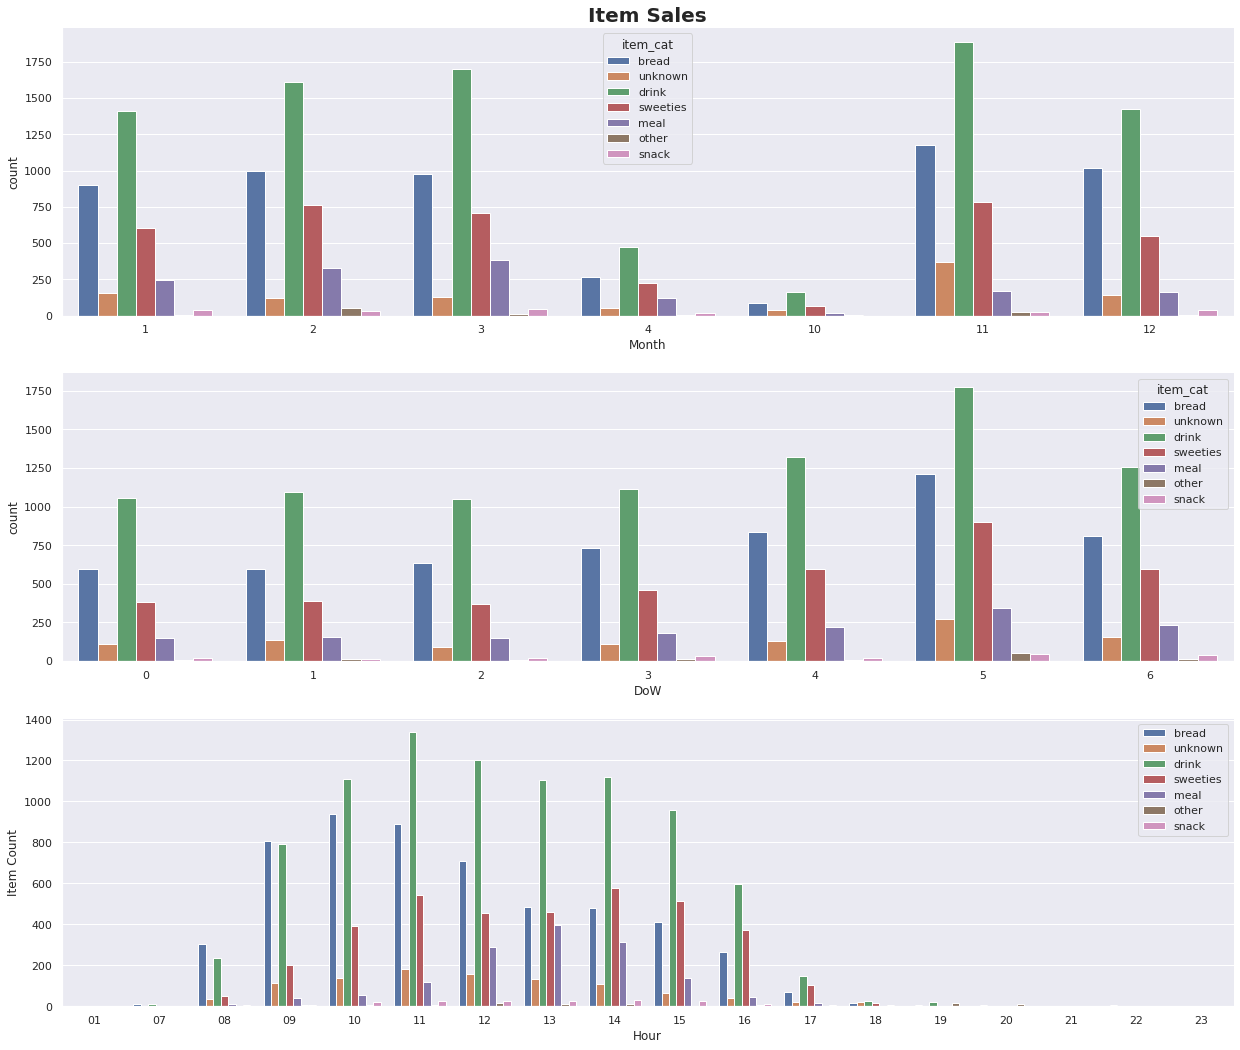

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(21, 18))
sns.countplot(x=df.Month.sort_values(), hue='item_cat', data=df,ax=ax1)
ax1.set_title("Item Sales",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.xlabel('Month')
plt.ylabel('Item Count')
plt.legend(loc='upper right')
sns.despine()
sns.countplot(x=df.DoW.sort_values(), hue='item_cat', data=df,ax=ax2)
# ax2.set_title("Item Sales",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.xlabel('Day of Week')
plt.ylabel('Item Count')
plt.legend(loc='upper right')
sns.despine()
sns.countplot(x=df.Hour.sort_values(), hue='item_cat', data=df,ax=ax3)
# ax3.set_title("Item Sales",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.xlabel('Hour')
plt.ylabel('Item Count')
plt.legend(loc='upper right')
sns.despine()

### Drink sales relat to time
We also analyse the drink sales relate to time, we selected **Coffee**, **Hot chocolate** and **Tea**. specifically.

As shown in the graph, the sales of these drink items grows proportionally as the total sales. 

In [44]:
df_drink = df[df['Item'].str.contains("Coffee$|Hot chocolate|Tea")]
df_drink.head()

,Date,Time_x,Transaction,Item,Hour,Time_y,Temperature,Dew Point,Humidity,Wind,...,Day,Month,DoW,Datetime,Sales,Rain,Fog,Cloud,Snow,item_cat
3,2016-10-30,10:07:57,3,Hot chocolate,10,10:50,55,50,82,W,...,30,10,6,2016-10-30 10:07:57,3,0.0,0.0,0.0,0.0,drink
7,2016-10-30,10:13:03,5,Coffee,10,10:50,55,50,82,W,...,30,10,6,2016-10-30 10:13:03,3,0.0,0.0,0.0,0.0,drink
15,2016-10-30,10:19:12,7,Coffee,10,10:50,55,50,82,W,...,30,10,6,2016-10-30 10:19:12,4,0.0,0.0,0.0,0.0,drink
16,2016-10-30,10:19:12,7,Tea,10,10:50,55,50,82,W,...,30,10,6,2016-10-30 10:19:12,4,0.0,0.0,0.0,0.0,drink
28,2016-10-30,10:30:14,12,Coffee,10,10:50,55,50,82,W,...,30,10,6,2016-10-30 10:30:14,5,0.0,0.0,0.0,0.0,drink


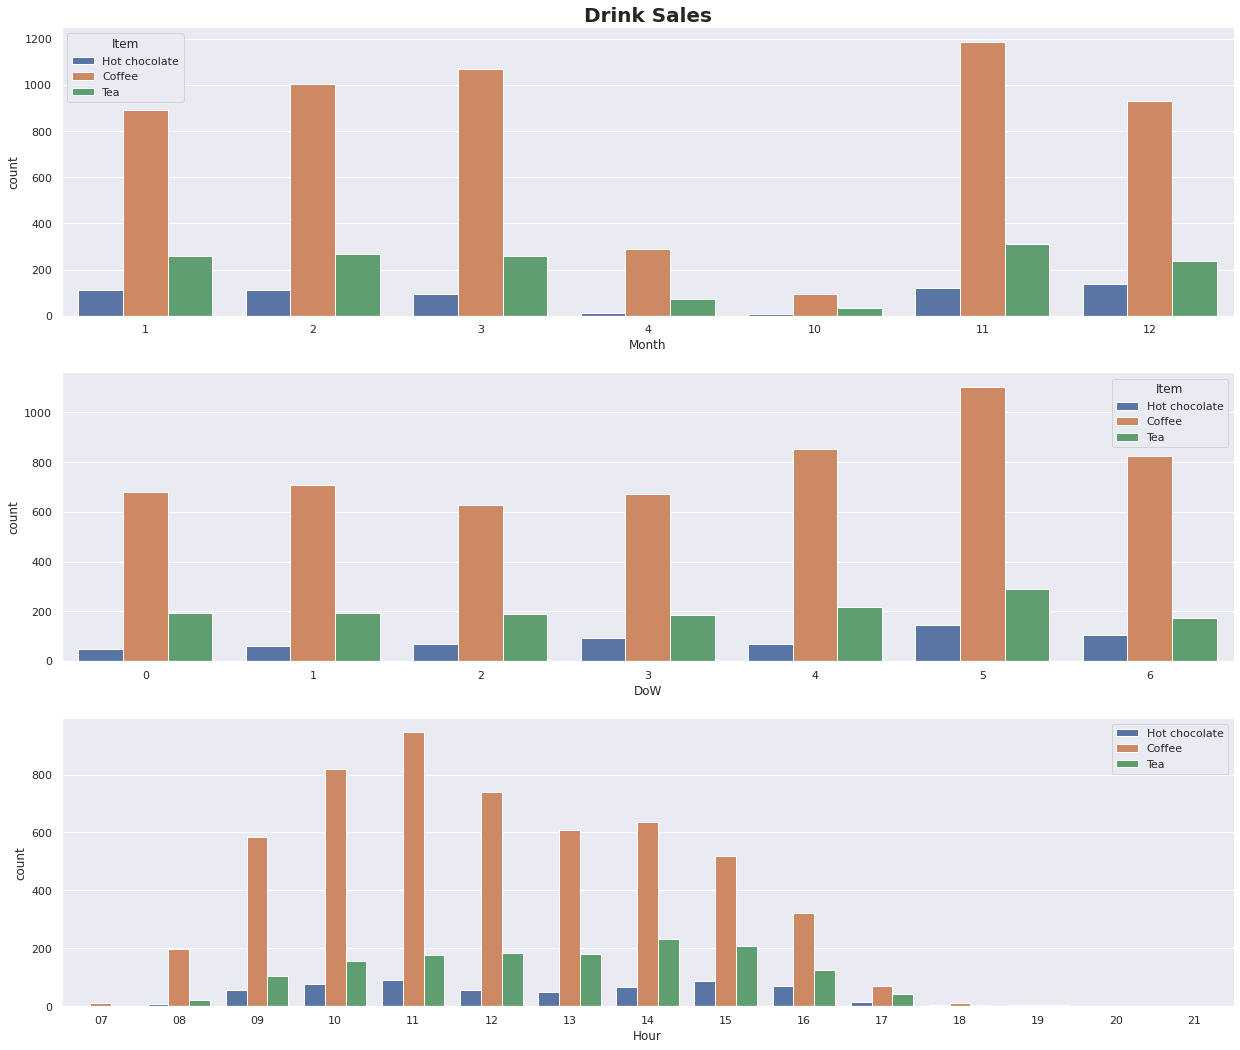

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(21, 18))
sns.countplot(x=df_drink.Month.sort_values(), hue='Item', data=df_drink,ax=ax1)
ax1.set_title("Drink Sales",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.xlabel('Month')
plt.legend(loc='upper right')
sns.despine()
sns.countplot(x=df_drink.DoW.sort_values(), hue='Item', data=df_drink,ax=ax2)
plt.xlabel('Day of Week')
plt.legend(loc='upper right')
sns.despine()
sns.countplot(x=df_drink.Hour.sort_values(), hue='Item', data=df_drink,ax=ax3)
plt.xlabel('Hour')
plt.legend(loc='upper right')
sns.despine()

# Summary

In this notebook, we have perform number of data analysis tasks.
First off, for the prediction task, our goal was to predict the correct sales data of bakery from given datetime information and the weather data.

**data preprocessing**
In data preprocessing stage, we have checked for missing value and remove outliners which do not hold valid information.

**feature engineering**
In order to have better exploitation to the data set, we did some feature engineering extract some information from the existing data.
For instance, we have created new features for specific weather condition(Rain, Fog, Cloud, Snow) based on the `Condition` column. We have grouped the `wind` direction and reduced unneceassary categories. For time-series data, we have also added lagged features, rolling average in order to improve the predictive performance.

**data transformation**
Before training, we have transformed the data to a suitable format and distribution. For numerical columns, we have normalized them such that the mean are centered at 0. For categorical columns, we have converted those columns into one hot vector. We have also considered the data leakage problem and removed the related columns.

**model training**
We have implemented two models: ANN and XGBoost, and compare their results by RMSE loss accordingly.
We have performed hyperparameter tuning to obtain the best hyperparameter for the model against training data.
The model have been evaluated with time-series cross-validation using the built-in function from library.
We have also essembled two model together and tried to get a better result.

**exploratory data analysis**
For the exploratory data analysis task, we have performed three tasks:

- Items that best sell together

We have implemented the apriori algorithm to perform basket analysis, and obtain the best set of items that sells together

- Sales relationship to **weather**

We have compared the average sales per transaction to different weather conditions.

- Number of sales in a transaction, relationship to the time of day

We have compared the category of items and its relation to different time span(Month, Day-of-week, and Hour).

After all we have succuessfully discover the insight and the hidden pattern from data set using approipate algorithms, data wrangling techniques, and visualization tools.
